
"CT scans plays a supportive role in the diagnosis of COVID-19 and is a key procedure for determining the severity that the patient finds himself in.
Models that can find evidence of COVID-19 and/or characterize its findings can play a crucial role in optimizing diagnosis and treatment, especially in areas with a shortage of expert radiologists.
This dataset contains 20 CT scans of patients diagnosed with COVID-19 as well as segmentations of lungs and infections made by experts."

Desafio do Kaggle: https://www.kaggle.com/andrewmvd/covid19-ct-scans

\\



In [ ]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from random import randint
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import random
from random import randint
import itertools 
import time
import psutil
import cv2
import os
import h5py


## **Importando Dataframes**

A seguir importamos o conjunto de imagens dos exames com tamanhos ajustados em 128x128 pixels:

In [ ]:
data = h5py.File('/content/drive/MyDrive/1-Projeto_Final_DL/Covid_Resized.h5','r')

ct_data = data['Resized_Images/ct_scan'][()]  
infection_data = data['Resized_Images/infection_mask'][()]  
lung_data = data['Resized_Images/lung_mask'][()] 

print('-------------------------------------------')
print(f'Número de imagens do pulmão: {len(ct_data)}')
print(f'Número de máscaras de infecção: {len(infection_data)}')
print(f'Número de máscaras do Pulmão: {len(lung_data)}')

print('-------------------------------------------')

-------------------------------------------
Número de imagens do pulmão: 3520
Número de máscaras de infecção: 3520
Número de máscaras do Pulmão: 3520
-------------------------------------------


# **Processando dos Dados**

## **Separando em Conjuntos de Treino, Teste e Validação**

O processo a seguir separa os dados em conjuntos de treino, validação e teste:

In [ ]:
from sklearn.model_selection import train_test_split

X = np.expand_dims(ct_data.copy(),axis=-1)
y = np.expand_dims(infection_data.copy(),axis=-1) 

X_train, ct_test, y_train, mask_test = train_test_split(X, y,test_size = 0.2)

ct_train, ct_val, mask_train, mask_val = train_test_split(X_train, y_train,test_size = 0.3)

Visualizando tamanho de cada dataset:

In [ ]:
print(f'---------------------- Dimensões dos Datasets ----------------------\n')
print(f'Imagens para o Treino: {ct_train.shape}\nMáscaras para o Treino: {mask_train.shape}\n')
print(f'Imagens para o Validação: {ct_val.shape}\nMáscaras para o Validação: {mask_val.shape}\n')
print(f'Imagens para o Teste: {ct_test.shape}\nMáscaras para o Teste: {mask_test.shape}\n')

---------------------- Dimensões dos Datasets ----------------------

Imagens para o Treino: (1971, 128, 128, 1)
Máscaras para o Treino: (1971, 128, 128, 1)

Imagens para o Validação: (845, 128, 128, 1)
Máscaras para o Validação: (845, 128, 128, 1)

Imagens para o Teste: (704, 128, 128, 1)
Máscaras para o Teste: (704, 128, 128, 1)



# **Configurando Modelo**

## **Métrica: Coeficiente de Jaccard-Tanimoto⁴**

O coeficiente de Jaccard-Tanimoto mede a similaridade entre conjuntos finitos, e é definido como:

\\
\begin{equation}\
  J(A,B) = \frac{A\cdot B}{\Vert A\Vert^2+\Vert B\Vert^2-A\cdot B},
\end{equation}

\\
onde:

\begin{equation}\
  A\cdot B = \sum_i A_iB_i,
\end{equation}

\begin{equation}\
  \Vert A\Vert ^2= \sum_i A_i^2.
\end{equation}

Obs.: Se $A$ e $B$ são conjuntos vazios então definimos $J(A,B)=1$.

\\
⁴ https://en.wikipedia.org/wiki/Jaccard_index




In [ ]:
# Modified from: 
# Author: n01z3
# https://www.kaggle.com/drn01z3/end-to-end-baseline-with-u-net-keras

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from keras import backend as K

smooth = 1e-3 # ~1/255.

# axis = [0,-2,-3]

def jaccard_fcoef(y_true, y_pred):


    intersection = K.sum(y_true * y_pred, axis=[0,-2,-3]) #Tensor: [image,width,height,depth]=[0,1,2,3]=[0,-3,-2,-1]
    sum_ = K.sum(y_true*y_true + y_pred*y_pred, axis=[0,-2,-3])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

# Colocar um if else dizendo para setar os pixels acima de umvalor para o valor 1

## **Métrica: Coeficiente de Dice⁵**

O coeficiente de é uma outra métrica popular na avaliação de problemas de segmentação semântica, assim como o coeficiente de Jaccard, ela visa medir a similaridade entre conjuntos finitos, e é definido como:

\\
\begin{equation}\
  D(A,B) = \frac{2A\cap B}{|A|+|B|}.
\end{equation}

\\
Obs.: Se $A$ e $B$ são conjuntos vazios então definimos $D(A,B)=1$.

Se a similaridade é expressa sobre um conjunto de vetores binários então:

\\
\begin{equation}\
  D(A,B) = \frac{2A\cdot B}{\Vert A\Vert^2+\Vert B\Vert^2},
\end{equation}

\\
onde:

\begin{equation}\
  A\cdot B = \sum_i A_iB_i,
\end{equation}

\begin{equation}\
  \Vert A\Vert = \sum_i A_i^2.
\end{equation}

\\
⁵ https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient



In [ ]:
smooth = 1e-3 # ~1/255.

# axis = [0,-2,-3]

def dice_coef(true, pred):
    y_true = K.cast(K.greater(K.clip(true, .4, 1), .4), K.floatx()) # Set pixels above .4 to 1 
    y_pred = K.cast(K.greater(K.clip(pred, .4, 1), .4), K.floatx())

    intersection = K.sum(y_true * y_pred, axis=[0,-2,-3]) #Tensor: [image,width,height,depth]=[0,1,2,3]=[0,-3,-2,-1]
    sum_ = K.sum(y_true*y_true + y_pred*y_pred, axis=[0,-2,-3])

    dice = 2*(intersection + smooth) / (sum_ + smooth)

    return K.mean(dice)

## **Loss: Binary Cross-Entropy (BCE)**


No problema apresentado, classificamos os pixels como pertencentes a região segmentada ou a região do *background*. Trantando assim de um problema de classificação binária. *Binary Cross-Entropy* é um caso especial da *Categorical Cross-Entropy* *loss* e é usada em problemas de classificação binária, por isso foi escolhida como medida da *loss* durante o processo de treino. A função loss *Binary Cross-Entropy* é calculada a partir da fórmula:

  \begin{equation}
    BCE = -\frac{1}{N}\sum^{N}_{i=1}y_i\cdot\log(\hat{y}_i)+(1-y_i)\cdot\log(1-\hat{y}_i), 
  \end{equation}

onde:

 $N=2$

 $y_i$ = label

 $\hat{y}_i$ = label's predicted probability

## **Modelo para Segmentação Semântica (U-Nnet)**

U-Net⁶ é uma rede neural convolucional desenvolvida para segmentação de imagens biomédicas. Ela é composta por um bloco contrator, responsável por extrair os *features* das imagens, e um bloco expansor, simétrico ao contrator, responsável pela reconstrução da imagem, com as dimensões originais, e localização dos *features* de interesse previstos pelo modelo.

⁶ [arXiv:1505.04597](https://)

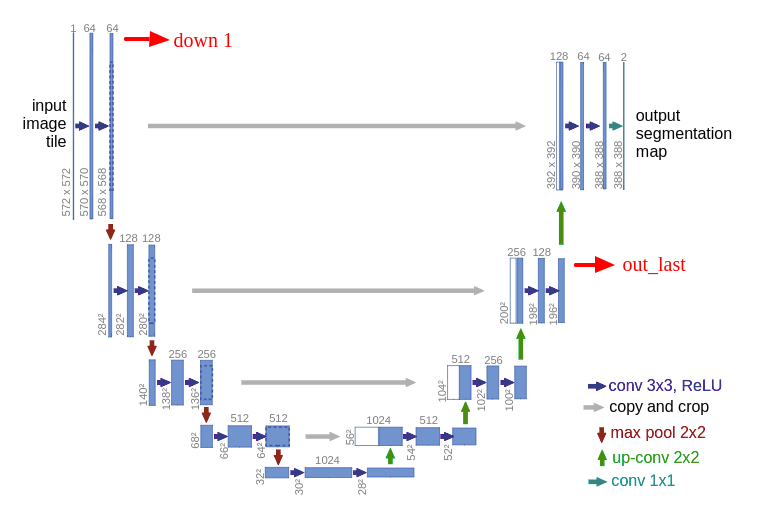

## **Definindo Bloco Convolucional da Rede**

In [ ]:
# Harshall Lamba 
# https://github.com/hlamba28/UNET-TGS/blob/master/TGS%20UNET.ipynb

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = False):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

# **Definindo Arquitetura da Rede**

In [ ]:
# Harshall Lamba 
# https://github.com/hlamba28/UNET-TGS/blob/master/TGS%20UNET.ipynb

def get_unet(input_img, n_filters, dropout, batchnorm):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# **Treino**

A partir das informações obtidas no processo de *Cross-Validation*, definimos o *learning rate* e número de filtros (input do modelo) as serem usados no treinamento do modelo:

In [ ]:
# Harshall Lamba 
# https://github.com/hlamba28/UNET-TGS/blob/master/TGS%20UNET.ipynb

input_img = Input((128, 128, 1))
model = get_unet(input_img, n_filters=14, dropout=0.3, batchnorm=False)

#model.summary()

Compilando o modelo:

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001), 
              loss="binary_crossentropy",
              metrics =[dice_coef]
              )

In [ ]:
from keras.callbacks import ModelCheckpoint

path = '/content/drive/MyDrive/1-Projeto_Final_DL/Pesos/model.h5'
checkpoint = ModelCheckpoint(path, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

Treinando modelo:

In [ ]:
start_time = time.time()
'----------------------------------------------------------------------------------------------------'

history = model.fit(ct_train,mask_train,
                    epochs = 50, 
                    validation_data = (ct_val, mask_val),
                    callbacks =checkpoint,
                    verbose=1,
                    )                    
'----------------------------------------------------------------------------------------------------'
print('\n--- time ---\n{:0.2f} min'.format(((time.time() - start_time))/60))

## **Avaliação do Treinamento**

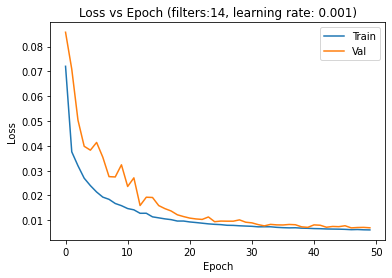

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epoch (filters:14, learning rate: 0.001)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc = 'upper right')
plt.show()

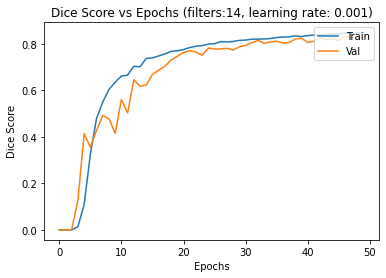

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Dice Score vs Epochs (filters:14, learning rate: 0.001)')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend(['Train', 'Val'], loc = 'upper right')
plt.show()

# **Avaliação do Modelo**

## **Cross-Validation**

In [ ]:
from sklearn.model_selection import KFold

history_df = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1

for train, test in kfold.split(X, y):
 
  input_img = Input((128, 128, 1))
  model_cv = get_unet(input_img, n_filters=14, dropout=0.3, batchnorm=False)

  '-------------------------------------------------------------------------------------------'

  model_cv.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001), 
                  loss="binary_crossentropy",
                  metrics =[jaccard_coef,dice_coef]
                  )
      
      # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...\n')

  # Fit data to model
  history_ = model_cv.fit(
            X[train],y[train],
            epochs=40,
            validation_data = (X[test],y[test]),
            batch_size = 100,
            verbose=0)

  # Create list with the history for each fold
  history_df.append(history_)

      
  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...

------------------------------------------------------------------------
Training for fold 2 ...

------------------------------------------------------------------------
Training for fold 3 ...



In [ ]:
pd.DataFrame.from_dict(history_df[0].history)

In [ ]:
df_ = pd.DataFrame()

for i in range(5):
  dd = pd.DataFrame.from_dict(history_df[i].history)
  df_ = pd.concat([df_,dd],axis=1)


In [ ]:
df_.to_csv('/content/drive/MyDrive/1-Projeto_Final_DL/CV_compara/cv_lung.csv',index=False)

## **Plotando Cross-Validation History**

Definindo função para plotar os dados a cross-validação:


In [ ]:
def plot_curve(data_1,data_2,title,y_label):
  
    train_sizes = np.linspace(1,len(data_1),len(data_1))
    train_scores_mean = data_1.mean(axis=1)
    train_scores_std = data_1.std(axis=1)
    test_scores_mean = data_2.mean(axis=1)
    test_scores_std = data_2.std(axis=1)
    
    plt.figure()
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel(y_label)
    
        
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="b")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, color="r", label="Train")
    plt.plot(train_sizes, test_scores_mean, color="b", label="Test")
    plt.legend()
    plt.xlim(1, len(data_1)) 

    plt.show()

# **Predição**
Avaliando modelo no conjunto de teste:

In [ ]:
scores = model.evaluate(ct_test, mask_test)

print(f'loss: {scores[0]}\nJaccard-Tanimoto Score: {scores[1]}\nDice Score: {scores[2]}')

22/22 [==============================] - 0s 18ms/step - loss: 0.0110 - jaccard_coef: 0.5967 - jaccard_fcoef: 0.6892
loss: 0.011007231660187244
Jaccard-Tanimoto Score: 0.5967462062835693
Dice Score: 0.6891606450080872


Fazendo predições com o modelo treinado:

In [ ]:
predicted = model.predict(ct_test)

## **Visualizando Predições**

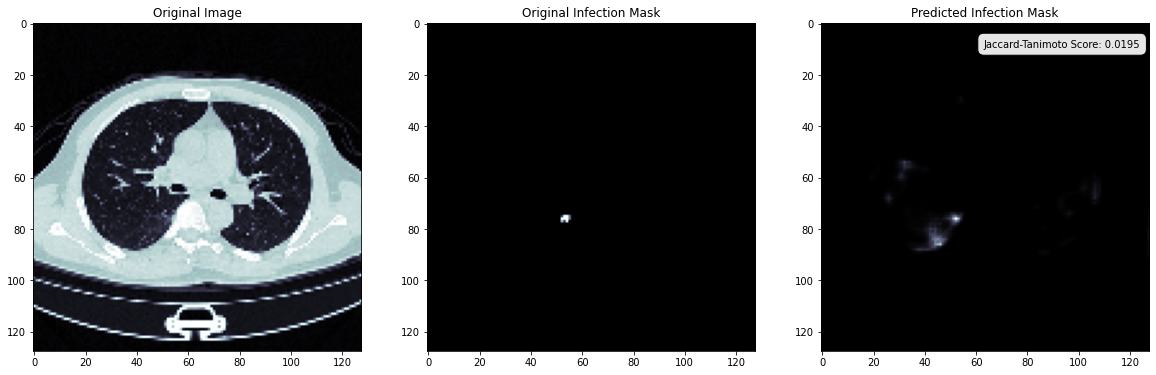

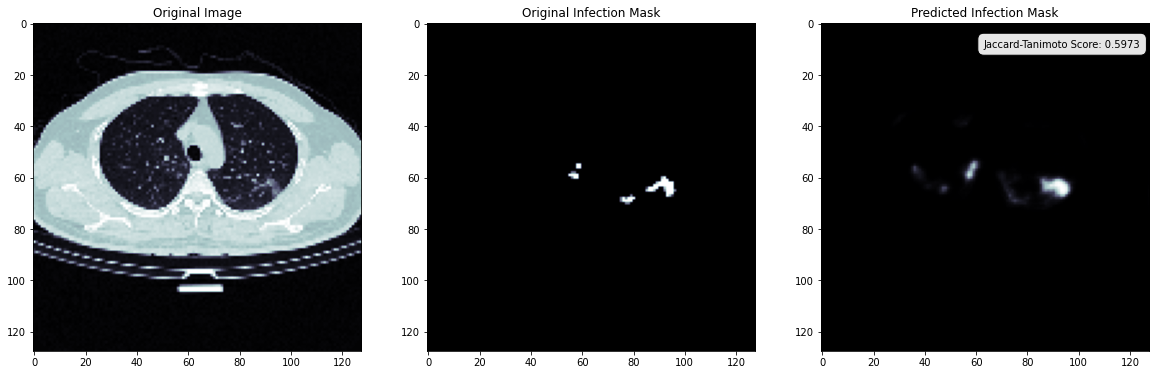

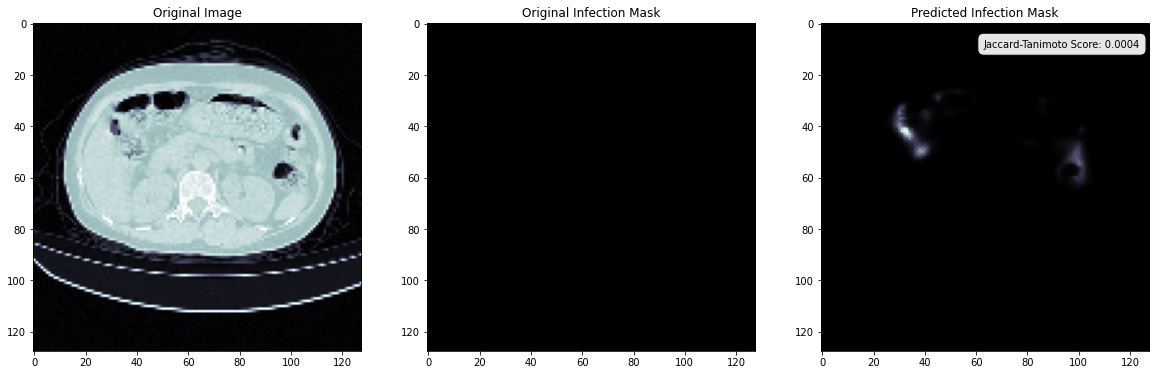

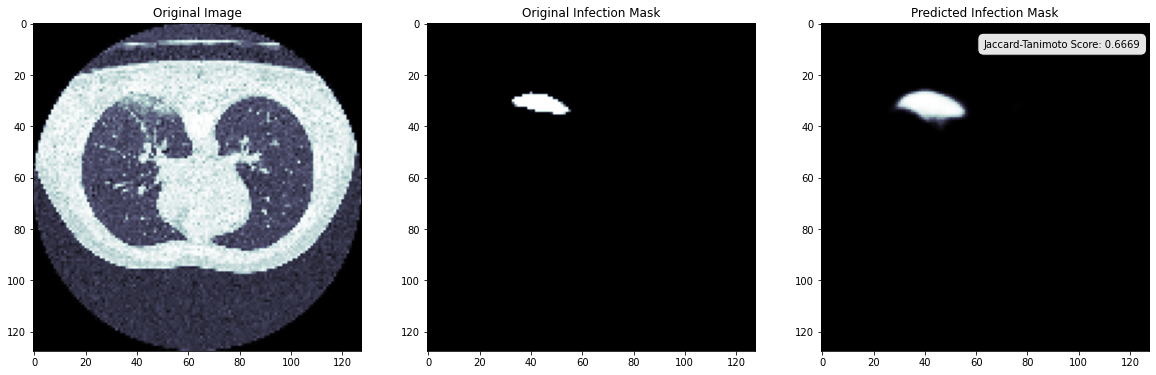

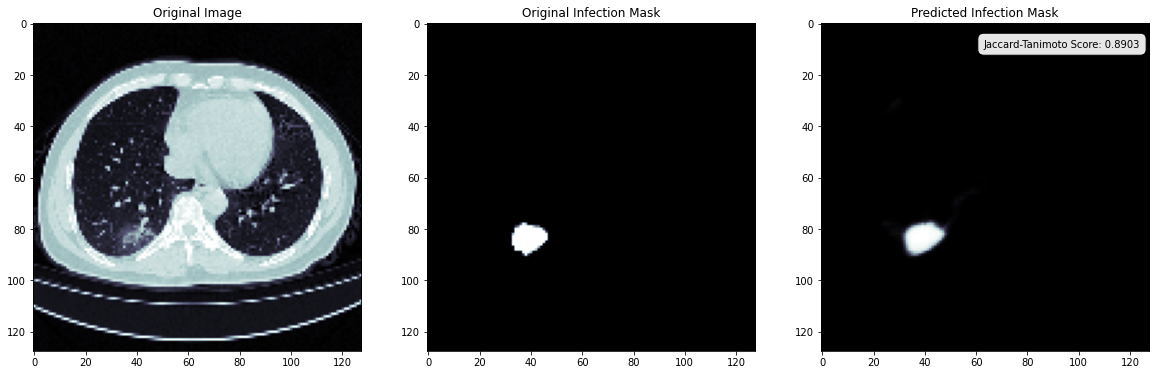

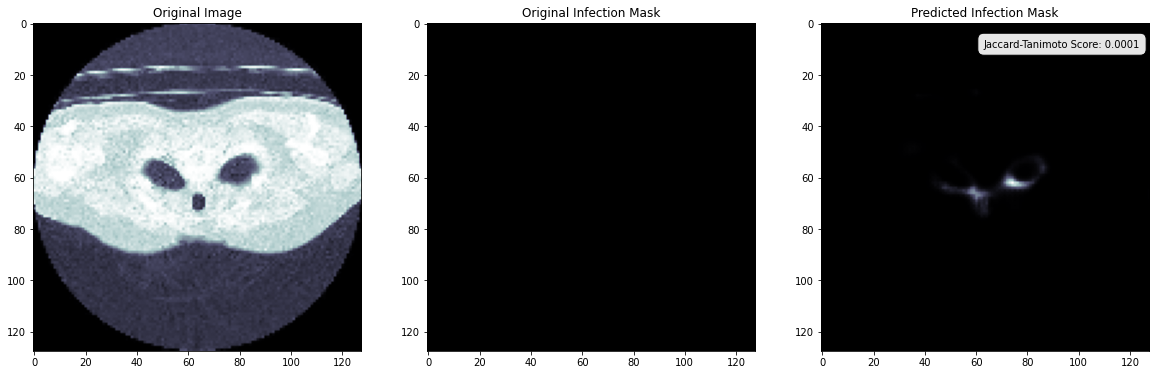

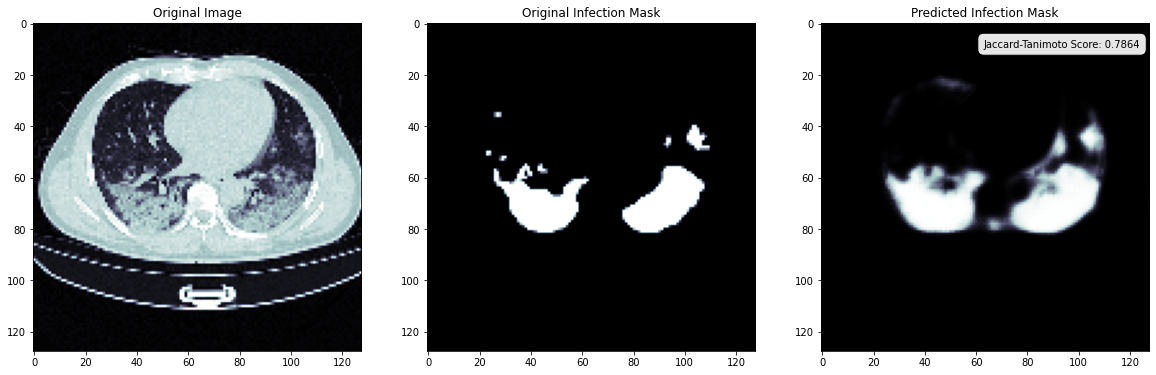

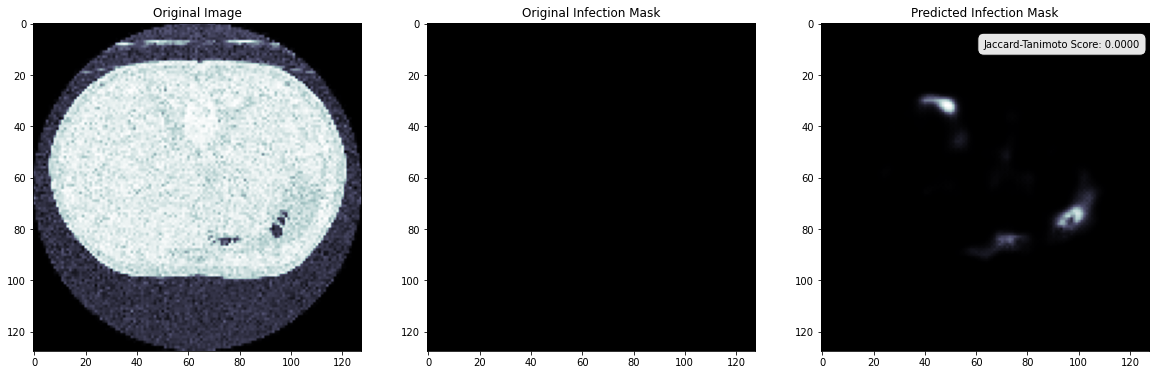

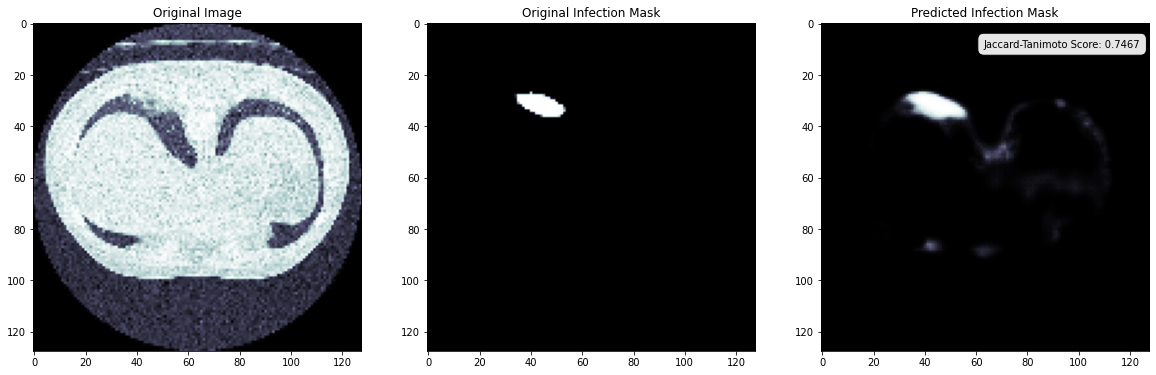

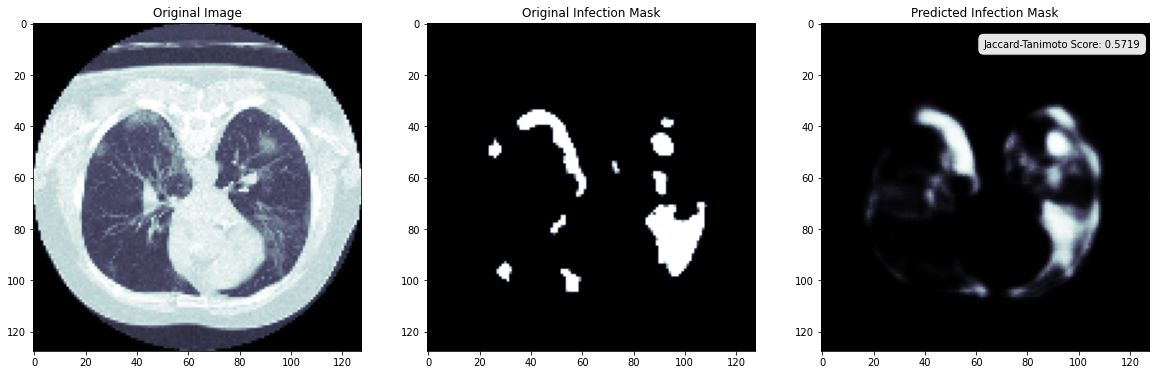

In [ ]:

for i in range(10):

  fig = plt.figure(figsize = (20,15))
  
  m = 10*i

  score = jaccard_fcoef(mask_test[m].astype('float32'),predicted[m].astype('float32'))

  plt.subplot(1,3,1)
  plt.imshow(ct_test[m][...,0], cmap = 'bone')
  plt.title('Original Image')

  plt.subplot(1,3,2)
  #plt.imshow(ct_val[m][...,0], cmap = 'bone')
  plt.imshow(mask_test[m][...,0],cmap = "bone")
  plt.title('Original Infection Mask')

  plt.subplot(1,3,3)
  #plt.imshow(ct_val[m][...,0], cmap = 'bone')
  plt.imshow(predicted[m][...,0],cmap = "bone")
  plt.annotate('Jaccard-Tanimoto Score: {:0.4f}'.format(score), xy=(63, 6),ha='left', va='top', bbox=dict(boxstyle="round,pad=.6", fc=".9",facecolor='white'))
  plt.title('Predicted Infection Mask')